# Resusing Functions Example

This notebook demonstrates the use of the subdag operator.

The subdag operator allows you to effectively run a driver within a node.
In this case, we are calculating unique website visitors from the following set of parameters:

1. Region = CA (canada) or US (United States)
2. Granularity of data = (day, week, month)

### Pre-requisites

You need to have the following installed and set up:
- Hamilton
- Pandas

Execute the code commented below to install the above if you don't have them already installed.

In [1]:
# %pip install sf-hamilton pandas

### Importing all the things you need


In [2]:
from typing import Any, Dict
import pandas as pd
from hamilton.base import ResultMixin, SimplePythonGraphAdapter
from hamilton import driver
%load_ext hamilton.plugins.jupyter_magic

`unique_users` module

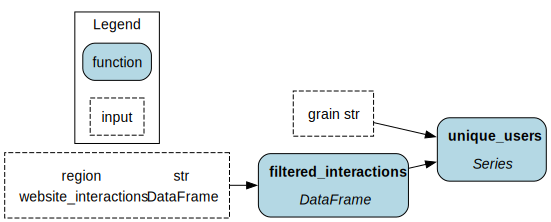

In [3]:
%%cell_to_module unique_users --display

import pandas as pd

_grain_mapping = {"day": "D", "week": "W", "month": "M"}


def _validate_grain(grain: str):
    assert grain in ["day", "week", "month"]


def filtered_interactions(website_interactions: pd.DataFrame, region: str) -> pd.DataFrame:
    return website_interactions[website_interactions.region == region]


def unique_users(filtered_interactions: pd.DataFrame, grain: str) -> pd.Series:
    """Gives the number of shares traded by the frequency"""
    _validate_grain(grain)
    return filtered_interactions.resample(_grain_mapping[grain])["user_id"].nunique()

`reusable_subdags` module

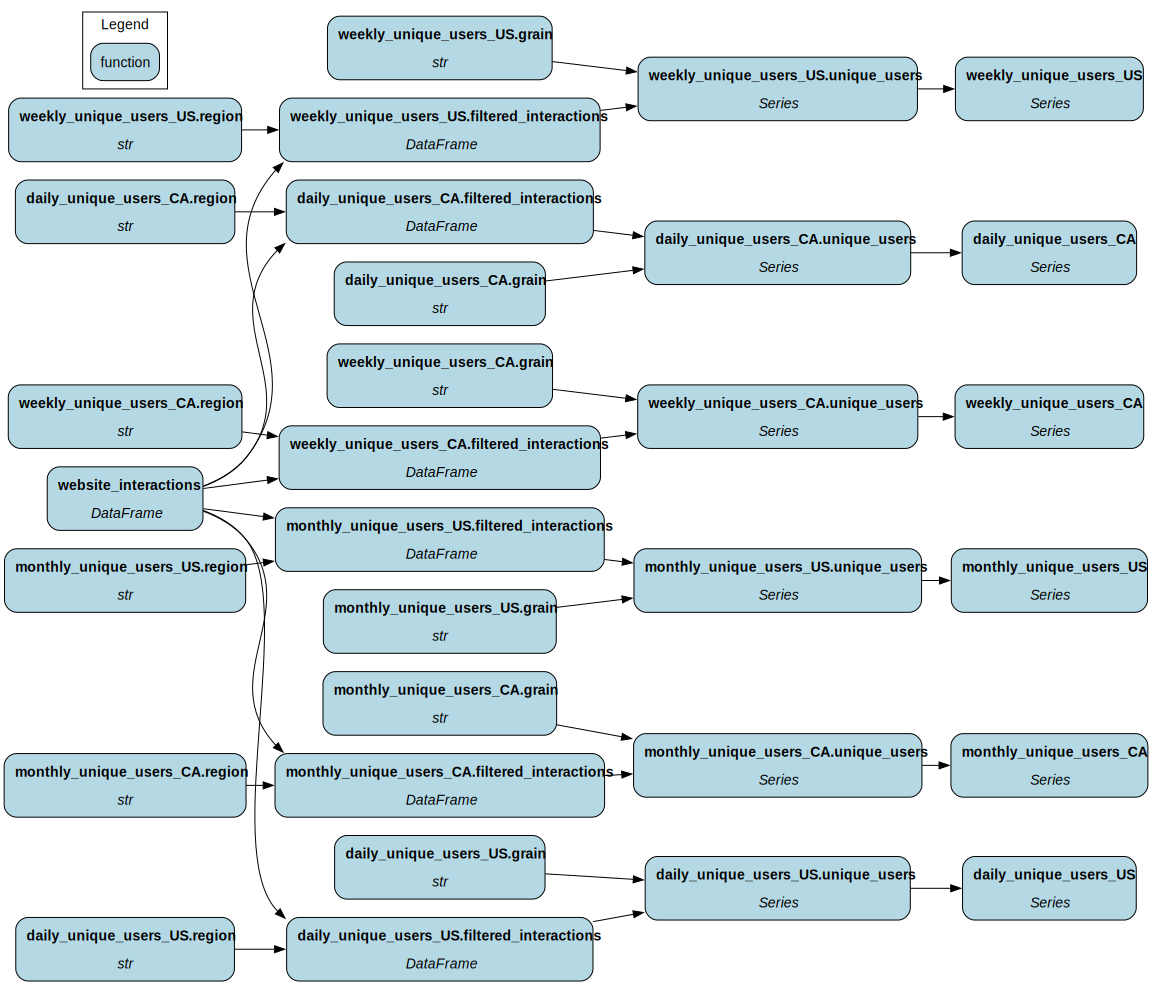

In [4]:
%%cell_to_module reusable_subdags --display
import pandas as pd
import unique_users

from hamilton.function_modifiers import subdag, value


def website_interactions() -> pd.DataFrame:
    """Gives event-driven data with a series

    :return: Some mock event data.
    """
    data = [
        ("20220901-14:00:00", 1, "US"),
        ("20220901-18:30:00", 2, "US"),
        ("20220901-19:00:00", 1, "US"),
        ("20220902-08:00:00", 3, "US"),
        ("20220903-16:00:00", 1, "US"),
        ("20220907-13:00:00", 4, "US"),
        ("20220910-14:00:00", 1, "US"),
        ("20220911-12:00:00", 3, "US"),
        ("20220914-11:00:00", 1, "US"),
        ("20220915-07:30:00", 2, "US"),
        ("20220916-06:00:00", 1, "US"),
        ("20220917-16:00:00", 2, "US"),
        ("20220920-17:00:00", 5, "US"),
        ("20220922-09:30:00", 2, "US"),
        ("20220922-10:00:00", 1, "US"),
        ("20220924-07:00:00", 6, "US"),
        ("20220924-08:00:00", 1, "US"),
        ("20220925-21:00:00", 1, "US"),
        ("20220926-15:30:00", 2, "US"),
        ("20220901-14:00:00", 7, "CA"),
        ("20220901-18:30:00", 8, "CA"),
        ("20220901-19:00:00", 9, "CA"),
        ("20220902-08:00:00", 7, "CA"),
        ("20220903-16:00:00", 10, "CA"),
        ("20220907-13:00:00", 9, "CA"),
        ("20220910-14:00:00", 8, "CA"),
        ("20220911-12:00:00", 11, "CA"),
        ("20220914-11:00:00", 12, "CA"),
        ("20220915-07:30:00", 7, "CA"),
        ("20220916-06:00:00", 9, "CA"),
        ("20220917-16:00:00", 10, "CA"),
        ("20220920-17:00:00", 7, "CA"),
        ("20220922-09:30:00", 11, "CA"),
        ("20220922-10:00:00", 8, "CA"),
        ("20220924-07:00:00", 9, "CA"),
        ("20220924-08:00:00", 10, "CA"),
        ("20220925-21:00:00", 13, "CA"),
        ("20220926-15:30:00", 14, "CA"),
    ]
    df = (
        pd.DataFrame(data, columns=["timestamp", "user_id", "region"])
        .set_index("timestamp")
        .sort_index()
    )
    df.index = pd.DatetimeIndex(df.index)
    return df


@subdag(
    unique_users,
    inputs={"grain": value("day")},
    config={"region": "US"},
)
def daily_unique_users_US(unique_users: pd.Series) -> pd.Series:
    return unique_users


@subdag(
    unique_users,
    inputs={"grain": value("week")},
    config={"region": "US"},
)
def weekly_unique_users_US(unique_users: pd.Series) -> pd.Series:
    return unique_users


@subdag(
    unique_users,
    inputs={"grain": value("month")},
    config={"region": "US"},
)
def monthly_unique_users_US(unique_users: pd.Series) -> pd.Series:
    return unique_users


@subdag(
    unique_users,
    inputs={"grain": value("day")},
    config={"region": "CA"},
)
def daily_unique_users_CA(unique_users: pd.Series) -> pd.Series:
    return unique_users


@subdag(
    unique_users,
    inputs={"grain": value("week")},
    config={"region": "CA"},
)
def weekly_unique_users_CA(unique_users: pd.Series) -> pd.Series:
    return unique_users


@subdag(
    unique_users,
    inputs={"grain": value("month")},
    config={"region": "CA"},
)
def monthly_unique_users_CA(unique_users: pd.Series) -> pd.Series:
    return unique_users

C:\Users\obeng\AppData\Local\Temp\tmpvmsp6sci.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return filtered_interactions.resample(_grain_mapping[grain])["user_id"].nunique()


            daily_unique_users_US  daily_unique_users_CA  \
timestamp                                                  
2022-09-01                    2.0                    3.0   
2022-09-02                    1.0                    1.0   
2022-09-03                    1.0                    1.0   
2022-09-04                    0.0                    0.0   
2022-09-05                    0.0                    0.0   
2022-09-06                    0.0                    0.0   
2022-09-07                    1.0                    1.0   
2022-09-08                    0.0                    0.0   
2022-09-09                    0.0                    0.0   
2022-09-10                    1.0                    1.0   
2022-09-11                    1.0                    1.0   
2022-09-12                    0.0                    0.0   
2022-09-13                    0.0                    0.0   
2022-09-14                    1.0                    1.0   
2022-09-15                    1.0       

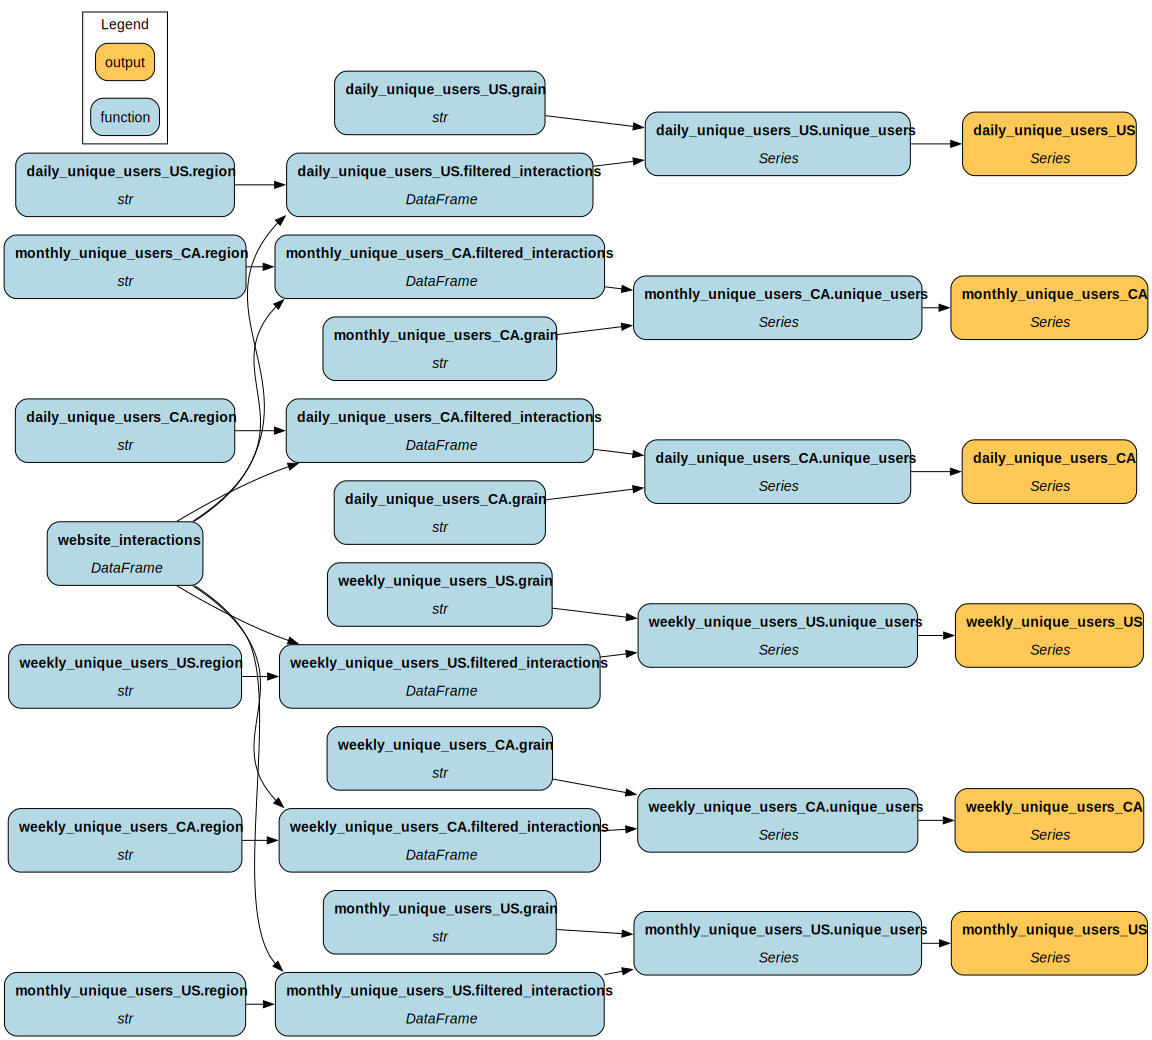

In [5]:
"""A pretty simple pipeline to demonstrate function reuse.
Note that this *also* demonstrates building a custom results builder!

Why not use the standard one? Well, because time-series joining is weird.
In this case, we're running the subdag for different granularities (daily, weekly, and monthly),
and we want the functions that provide outputs for these granularities to yield one
row per datapoint. This means that the weekly series will have 7x less much data as the daily
series. Monthly series will have less than the weekly series, etc...

This results builder handles it by upsampling them all to a specified granularity.

Specifically, it:
1. Up/down-samples all time-series to the granularity specified in the constructor
2. Joins them as normal (a full outer join)

Note that pandas also has capabilities for as-of joins, but those tend to be messy and tricky to work
with. Furthermore, the as-of joins don't usually work with multiple. Upsampling/downsampling does the
trick quite well and adds more control to the user.

Note that it might be nice to pass in an argument to say which data is the "spine" column,
allowing us to have a basis of data to join with. For now, however, this should be a useful piece
of code to help with time-series joining!

Furthermore, you could actually include upsampling *in* the DAG -- this has the added feature of
encoding an index/spine column, and could be run as the final step for each subdag. Doing so is left
as an exercise to the reader.

As an example, consider the following outputs:
1. monthly_unique_users_US

timestamp
2022-09-30    6
Freq: M, Name: user_id, dtype: int64

2. weekly_unique_users_US

2022-09-04    3
2022-09-11    3
2022-09-18    2
2022-09-25    4
2022-10-02    1
Freq: W-SUN, Name: user_id, dtype: int64

3. daily_unique_users_US
timestamp
2022-09-01    2
2022-09-02    1
2022-09-03    1
2022-09-04    0
...
2022-09-22    2
2022-09-23    0
2022-09-24    2
2022-09-25    1
2022-09-26    1
Freq: D, Name: user_id, dtype: int64

Joining these with upsample granularity of "D" would produce:

            daily_unique_users_US  weekly_unique_users_US  monthly_unique_users_US
timestamp
2022-09-01                    2.0                     3.0                      6.0
2022-09-02                    1.0                     3.0                      6.0
2022-09-03                    1.0                     3.0                      6.0
2022-09-04                    0.0                     3.0                      6.0
2022-09-05                    0.0                     3.0                      6.0
2022-09-06                    0.0                     3.0                      6.0
...
2022-09-28                    NaN                     1.0                      6.0
2022-09-29                    NaN                     1.0                      6.0
2022-09-30                    NaN                     1.0                      6.0
2022-10-01                    NaN                     1.0                      NaN
2022-10-02                    NaN                     1.0                      NaN
"""


class TimeSeriesJoinResultsBuilder(ResultMixin):
    def __init__(self, upsample_frequency: str):
        """Initializes a results builder that does a time-series join
        :param upsample_frequency: Argument to pandas sample() function.
        """
        self.sampling_methodology = upsample_frequency

    def resample(self, time_series: pd.Series):
        return time_series.resample(
            self.sampling_methodology
        ).bfill()  # TODO -- think through the right fill -- ffill()/bfill()/whatnot

    @staticmethod
    def is_time_series(series: Any):
        if not isinstance(series, pd.Series):
            return False
        if not series.index.inferred_type == "datetime64":
            return False
        return True

    def build_result(self, **outputs: Dict[str, Any]) -> Any:
        non_ts_output = [
            key
            for key, value in outputs.items()
            if not TimeSeriesJoinResultsBuilder.is_time_series(value)
        ]
        if len(non_ts_output) > 0:
            raise ValueError(
                f"All outputs from DAG must be time-series -- the following are not: {non_ts_output}"
            )
        resampled_results = {key: self.resample(value) for key, value in outputs.items()}
        return pd.DataFrame(resampled_results).bfill()



dr = (driver.Builder()
    .with_config({})
    .with_modules(reusable_subdags)
    .with_adapters(SimplePythonGraphAdapter(
        result_builder=TimeSeriesJoinResultsBuilder(upsample_frequency="D")
    ),
)

result = dr.execute(
    [
        "daily_unique_users_US",
        "daily_unique_users_CA",
        "weekly_unique_users_US",
        "weekly_unique_users_CA",
        "monthly_unique_users_US",
        "monthly_unique_users_CA",
    ]
)
execution_graph = dr.visualize_execution([
        "daily_unique_users_US",
        "daily_unique_users_CA",
        "weekly_unique_users_US",
        "weekly_unique_users_CA",
        "monthly_unique_users_US",
        "monthly_unique_users_CA",
    ], "./reusable_subdags", {"format": "png"})

print(result)
display(execution_graph)